In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, recall_score, precision_score, 
    accuracy_score, roc_auc_score, roc_curve
)
import joblib

# Cargar el dataset
df = pd.read_csv("dataset_rio_1km_week_encoded.csv")

print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
print("\nPrimeras filas:")
print(df.head())

print("\nInformación del dataset:")
df.info()

Dataset cargado: 5531 filas, 27 columnas

Primeras filas:
   Code Departamento  distanciaRio  hayRioCercano  temperature_2m  \
0              54028          8.07          False       18.305905   
1               6427          4.98          False       25.878348   
2              50007         42.83          False       23.260704   
3              14063         15.81          False       23.013005   
4              14063         15.81          False       23.013005   

   total_evaporation_sum  volumetric_soil_water_layer_1  precipitation_week  \
0               1.148527                       0.467691               172.5   
1               3.236035                       0.206117                73.1   
2               0.983669                       0.165721                69.9   
3               3.030844                       0.458341                63.5   
4               3.030844                       0.458341                63.5   

   tipoDeSuelo_Alfisoles  tipoDeSuelo_Aridisoles  \


In [2]:
# Preparar entradas (X) y salida (y) para el modelo

print("Columnas disponibles:\n", df.columns.tolist())
print("\nShape del dataframe:", df.shape)

# --- Definir target y features ---
target = 'seInunda'

# Columnas a usar como features
features = ['hayRioCercano', 'temperature_2m', 'total_evaporation_sum', 
            'volumetric_soil_water_layer_1', 'precipitation_week', 
            'tipoDeSuelo_Alfisoles', 'tipoDeSuelo_Aridisoles',
            'tipoDeSuelo_Complejo indiferenci', 'tipoDeSuelo_Entisoles',
            'tipoDeSuelo_Esteros', 'tipoDeSuelo_Inceptisoles',
            'tipoDeSuelo_Lagunas', 'tipoDeSuelo_Medano', 'tipoDeSuelo_Miscelaneas',
            'tipoDeSuelo_Molisoles', 'tipoDeSuelo_Rio', 'tipoDeSuelo_Roca',
            'tipoDeSuelo_Salinas', 'tipoDeSuelo_Ultisoles',
            'tipoDeSuelo_Vertisoles', 'estacion_invierno', 'estacion_otoño',
            'estacion_primavera', 'estacion_verano']

print(f"\nTarget: {target}")
print(f"Features: {len(features)} columnas")

# Verificar que todas las columnas existen
columnas_faltantes = [col for col in features if col not in df.columns]
if columnas_faltantes:
    print(f"\n⚠️ ADVERTENCIA: Columnas faltantes: {columnas_faltantes}")
else:
    print("\n✓ Todas las columnas requeridas están presentes")

# --- Preparar X (features) y y (target) ---
X = df[features].to_numpy(dtype=float)
y = df[target].to_numpy()

# Convertir booleanos a 1/0 si es necesario
y = y.astype(int)

print(f"\nShapes: X={X.shape}, y={y.shape}")
print(f"Distribución del target: {np.bincount(y)} (0=No Inunda, 1=Inunda)")
print(f"  - No Inunda: {np.sum(y==0)} ({100*np.sum(y==0)/len(y):.1f}%)")
print(f"  - Inunda: {np.sum(y==1)} ({100*np.sum(y==1)/len(y):.1f}%)")

# --- Split train/test con estratificación ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nShapes después del split:")
print(f"  X_train={X_train.shape}, y_train={y_train.shape}")
print(f"  X_test={X_test.shape}, y_test={y_test.shape}")

# --- Escalado (StandardScaler) ---
# Aunque Random Forest no lo requiere estrictamente, puede ayudar con la interpretación
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Datos preparados y listos para el modelo!")
print(f"\n📌 Variables disponibles:")
print(f"   - X_train_scaled, X_test_scaled: datos escalados")
print(f"   - X_train, X_test: datos sin escalar")
print(f"   - y_train, y_test: etiquetas binarias (0/1)")
print(f"   - features: lista de nombres de columnas usadas")

Columnas disponibles:
 ['Code Departamento', 'distanciaRio', 'hayRioCercano', 'temperature_2m', 'total_evaporation_sum', 'volumetric_soil_water_layer_1', 'precipitation_week', 'tipoDeSuelo_Alfisoles', 'tipoDeSuelo_Aridisoles', 'tipoDeSuelo_Complejo indiferenci', 'tipoDeSuelo_Entisoles', 'tipoDeSuelo_Esteros', 'tipoDeSuelo_Inceptisoles', 'tipoDeSuelo_Lagunas', 'tipoDeSuelo_Medano', 'tipoDeSuelo_Miscelaneas', 'tipoDeSuelo_Molisoles', 'tipoDeSuelo_Rio', 'tipoDeSuelo_Roca', 'tipoDeSuelo_Salinas', 'tipoDeSuelo_Ultisoles', 'tipoDeSuelo_Vertisoles', 'estacion_invierno', 'estacion_otoño', 'estacion_primavera', 'estacion_verano', 'seInunda']

Shape del dataframe: (5531, 27)

Target: seInunda
Features: 24 columnas

✓ Todas las columnas requeridas están presentes

Shapes: X=(5531, 24), y=(5531,)
Distribución del target: [2805 2726] (0=No Inunda, 1=Inunda)
  - No Inunda: 2805 (50.7%)
  - Inunda: 2726 (49.3%)

Shapes después del split:
  X_train=(4424, 24), y_train=(4424,)
  X_test=(1107, 24), y_te

In [3]:
# Búsqueda de hiperparámetros para Random Forest
# OBJETIVO: Maximizar F1-Score y Recall

print("="*70)
print("🔍 BÚSQUEDA DE HIPERPARÁMETROS PARA RANDOM FOREST")
print("="*70)
print("\nObjetivo: Maximizar F1-Score (balance entre Precision y Recall)")
print("Prioridad secundaria: Maximizar Recall (detectar todas las inundaciones)\n")

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],  # Número de árboles
    'max_depth': [10, 20, 30, 40, 50, None],  # Profundidad máxima
    'min_samples_split': [2, 5, 10, 15],  # Mínimo de muestras para dividir
    'min_samples_leaf': [1, 2, 4, 8],  # Mínimo de muestras en hoja
    'max_features': ['sqrt', 'log2', None],  # Número de features a considerar
    'bootstrap': [True, False],  # Bootstrap samples
    'class_weight': ['balanced', 'balanced_subsample', None]  # Pesos de clase
}

print(f"Espacio de búsqueda definido con {len(param_grid)} hiperparámetros")
print(f"Combinaciones posibles: {5*6*4*4*3*2*3:,}\n")

# Usar RandomizedSearchCV para eficiencia (explorar aleatoriamente el espacio)
# Métrica principal: f1_score
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# RandomizedSearchCV con scoring en f1
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=100,  # Número de combinaciones aleatorias a probar
    scoring='f1',  # Métrica principal: F1-Score
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

print("Iniciando búsqueda aleatoria de hiperparámetros...")
print("Esto puede tomar varios minutos (100 combinaciones × 5 folds = 500 entrenamientos)\n")

# Entrenar
random_search.fit(X_train, y_train)  # Random Forest no necesita datos escalados

print("\n" + "="*70)
print("🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:")
print("="*70)
best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nMejor F1-Score en validación cruzada: {random_search.best_score_:.4f}")
print("="*70)

# Obtener el mejor modelo
best_rf = random_search.best_estimator_

print("\n✓ Modelo con mejores hiperparámetros entrenado")

🔍 BÚSQUEDA DE HIPERPARÁMETROS PARA RANDOM FOREST

Objetivo: Maximizar F1-Score (balance entre Precision y Recall)
Prioridad secundaria: Maximizar Recall (detectar todas las inundaciones)

Espacio de búsqueda definido con 7 hiperparámetros
Combinaciones posibles: 8,640

Iniciando búsqueda aleatoria de hiperparámetros...
Esto puede tomar varios minutos (100 combinaciones × 5 folds = 500 entrenamientos)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:
  n_estimators: 100
  min_samples_split: 5
  min_samples_leaf: 1
  max_features: sqrt
  max_depth: 20
  class_weight: None
  bootstrap: True

Mejor F1-Score en validación cruzada: 0.7721

✓ Modelo con mejores hiperparámetros entrenado


In [4]:
# Evaluar el mejor modelo en el conjunto de test

print("="*70)
print("📈 EVALUACIÓN EN EL CONJUNTO DE TEST")
print("="*70)

# Predicciones
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Calcular métricas
test_accuracy = accuracy_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nMétricas principales:")
print(f"  F1-Score:  {test_f1:.4f}  ← ¡Métrica objetivo!")
print(f"  Recall:    {test_recall:.4f}  ← ¡Prioridad secundaria!")
print(f"  Precision: {test_precision:.4f}")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  AUC-ROC:   {test_auc:.4f}")

print("\n" + "="*70)

# Guardar el modelo
joblib.dump(best_rf, 'mejor_random_forest.pkl')
joblib.dump(scaler, 'scaler_random_forest.pkl')

print("\n✅ Modelo guardado como 'mejor_random_forest.pkl'")
print("✅ Scaler guardado como 'scaler_random_forest.pkl'")

📈 EVALUACIÓN EN EL CONJUNTO DE TEST

Métricas principales:
  F1-Score:  0.7804  ← ¡Métrica objetivo!
  Recall:    0.7875  ← ¡Prioridad secundaria!
  Precision: 0.7734
  Accuracy:  0.7814
  AUC-ROC:   0.8653


✅ Modelo guardado como 'mejor_random_forest.pkl'
✅ Scaler guardado como 'scaler_random_forest.pkl'


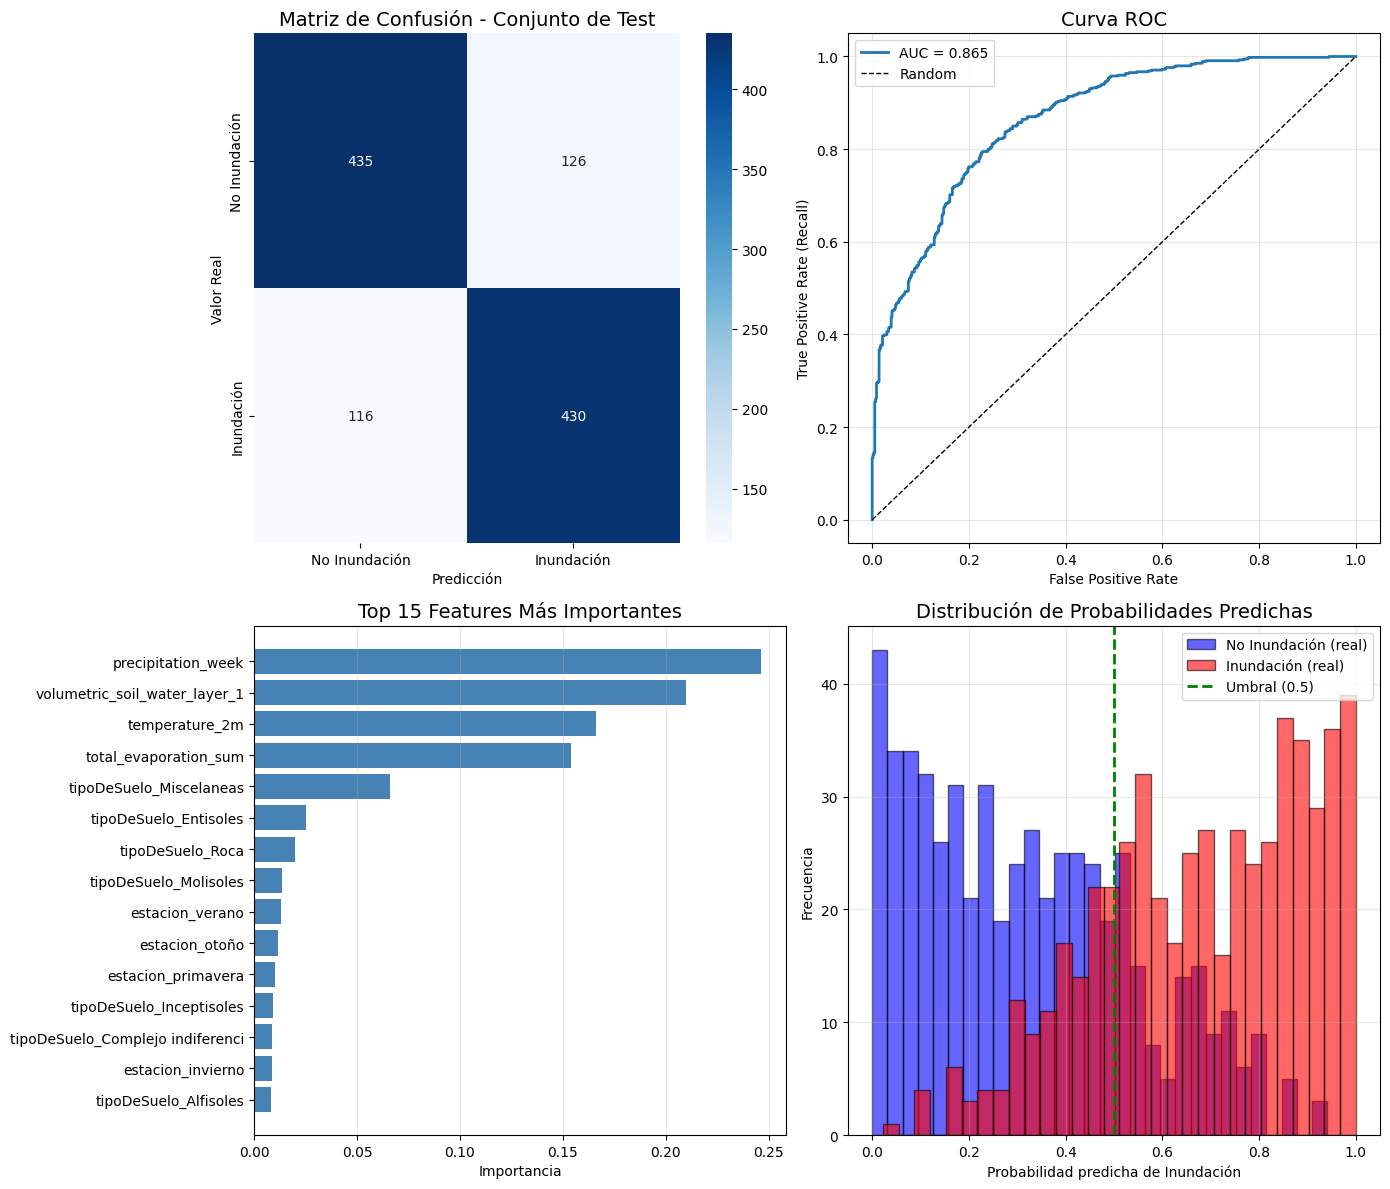


📊 REPORTE DE CLASIFICACIÓN DETALLADO
               precision    recall  f1-score   support

No Inundación     0.7895    0.7754    0.7824       561
   Inundación     0.7734    0.7875    0.7804       546

     accuracy                         0.7814      1107
    macro avg     0.7814    0.7815    0.7814      1107
 weighted avg     0.7815    0.7814    0.7814      1107


📊 IMPORTANCIA DE TODAS LAS FEATURES
                         feature  importance
              precipitation_week    0.246217
   volumetric_soil_water_layer_1    0.209927
                  temperature_2m    0.166235
           total_evaporation_sum    0.153770
         tipoDeSuelo_Miscelaneas    0.065984
           tipoDeSuelo_Entisoles    0.025330
                tipoDeSuelo_Roca    0.019882
           tipoDeSuelo_Molisoles    0.013355
                 estacion_verano    0.013246
                  estacion_otoño    0.011619
              estacion_primavera    0.010341
        tipoDeSuelo_Inceptisoles    0.009000
tipoDeS

In [5]:
# Visualización de resultados

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No Inundación', 'Inundación'],
            yticklabels=['No Inundación', 'Inundación'])
axes[0, 0].set_title('Matriz de Confusión - Conjunto de Test', fontsize=14)
axes[0, 0].set_ylabel('Valor Real')
axes[0, 0].set_xlabel('Predicción')

# 2. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'AUC = {test_auc:.3f}')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate (Recall)')
axes[0, 1].set_title('Curva ROC', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Importancia de features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

top_features = feature_importance.head(15)
axes[1, 0].barh(range(len(top_features)), top_features['importance'], color='steelblue')
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['feature'])
axes[1, 0].invert_yaxis()
axes[1, 0].set_xlabel('Importancia')
axes[1, 0].set_title('Top 15 Features Más Importantes', fontsize=14)
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Distribución de probabilidades predichas
axes[1, 1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.6, 
                label='No Inundación (real)', color='blue', edgecolor='black')
axes[1, 1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.6, 
                label='Inundación (real)', color='red', edgecolor='black')
axes[1, 1].axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Umbral (0.5)')
axes[1, 1].set_xlabel('Probabilidad predicha de Inundación')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Probabilidades Predichas', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\n" + "="*70)
print("📊 REPORTE DE CLASIFICACIÓN DETALLADO")
print("="*70)
print(classification_report(y_test, y_pred, 
                          target_names=['No Inundación', 'Inundación'],
                          digits=4))

# Mostrar importancia de features completa
print("\n" + "="*70)
print("📊 IMPORTANCIA DE TODAS LAS FEATURES")
print("="*70)
print(feature_importance.to_string(index=False))

In [6]:
# 🎯 Predicciones con probabilidades y análisis

print("="*70)
print("📊 PREDICCIONES CON PROBABILIDADES")
print("="*70)

# Mostrar ejemplos de predicciones
print("\nEjemplos de predicciones (primeros 20 casos del test):")
print("-" * 70)
print(f"{'Índice':<8} {'Probabilidad':<15} {'Predicción':<18} {'Real':<15} {'Estado'}")
print("-" * 70)

for i in range(min(20, len(y_test))):
    prob = y_pred_proba[i]
    pred_class = "Inundación" if prob > 0.5 else "No Inundación"
    real_class = "Inundación" if y_test[i] == 1 else "No Inundación"
    correcto = "✓" if (prob > 0.5) == (y_test[i] == 1) else "✗"
    
    print(f"{i:<8} {prob:>6.4f} ({prob*100:5.1f}%)   {pred_class:<18} {real_class:<15} {correcto}")

print("-" * 70)

# Distribución de probabilidades
print("\n📈 Distribución de probabilidades predichas:")
print(f"  Mínimo: {y_pred_proba.min():.4f}")
print(f"  Máximo: {y_pred_proba.max():.4f}")
print(f"  Media: {y_pred_proba.mean():.4f}")
print(f"  Mediana: {np.median(y_pred_proba):.4f}")

# Análisis de errores
print("\n" + "="*70)
print("⚠️  ANÁLISIS DE ERRORES")
print("="*70)

# Falsos Positivos (predice inundación pero no ocurre)
fp_indices = np.where((y_pred == 1) & (y_test == 0))[0]
print(f"\nFalsos Positivos: {len(fp_indices)}")
if len(fp_indices) > 0:
    print(f"  Probabilidades promedio: {y_pred_proba[fp_indices].mean():.4f}")

# Falsos Negativos (no predice inundación pero sí ocurre) ← MÁS GRAVE
fn_indices = np.where((y_pred == 0) & (y_test == 1))[0]
print(f"\nFalsos Negativos: {len(fn_indices)} ← ¡CRÍTICO!")
if len(fn_indices) > 0:
    print(f"  Probabilidades promedio: {y_pred_proba[fn_indices].mean():.4f}")
    print(f"  Estos son los casos más graves: inundaciones no detectadas")

# Verdaderos Positivos
tp_indices = np.where((y_pred == 1) & (y_test == 1))[0]
print(f"\nVerdaderos Positivos: {len(tp_indices)}")
if len(tp_indices) > 0:
    print(f"  Probabilidades promedio: {y_pred_proba[tp_indices].mean():.4f}")

# Verdaderos Negativos
tn_indices = np.where((y_pred == 0) & (y_test == 0))[0]
print(f"\nVerdaderos Negativos: {len(tn_indices)}")
if len(tn_indices) > 0:
    print(f"  Probabilidades promedio: {y_pred_proba[tn_indices].mean():.4f}")

print("\n" + "="*70)
print("ℹ️  INTERPRETACIÓN")
print("="*70)
print("• F1-Score: Balance entre Precision y Recall")
print("• Recall alto: Detecta la mayoría de las inundaciones (minimiza FN)")
print("• Precision alta: Pocas falsas alarmas (minimiza FP)")
print("• En este problema, RECALL es más importante que Precision")
print("  (Mejor tener falsas alarmas que no detectar inundaciones)")
print("="*70)

# Función auxiliar para predicciones
def predecir_inundacion_rf(datos_nuevos, mostrar_detalle=True):
    """
    Predice la probabilidad de inundación usando Random Forest.
    
    Args:
        datos_nuevos: array o DataFrame con las mismas features
        mostrar_detalle: si True, muestra interpretación detallada
    
    Returns:
        probabilidad: valor entre 0 y 1
    """
    # Predecir (Random Forest no necesita escalado, pero lo aplicamos por consistencia)
    prob = best_rf.predict_proba(datos_nuevos)[0, 1]
    
    if mostrar_detalle:
        print(f"\n🔮 Predicción Random Forest:")
        print(f"   Probabilidad de inundación: {prob:.4f} ({prob*100:.2f}%)")
        print(f"   Probabilidad de NO inundación: {1-prob:.4f} ({(1-prob)*100:.2f}%)")
        
        if prob > 0.8:
            print(f"   ⚠️  ALTA probabilidad de inundación")
        elif prob > 0.5:
            print(f"   ⚡ Probabilidad moderada de inundación")
        elif prob > 0.2:
            print(f"   ✓ Baja probabilidad de inundación")
        else:
            print(f"   ✓✓ MUY baja probabilidad de inundación")
    
    return prob

print("\n💡 Para usar el modelo con nuevos datos:")
print("   probabilidad = predecir_inundacion_rf(datos_nuevos)")
print("   donde 'datos_nuevos' debe tener las mismas columnas que X_train")

📊 PREDICCIONES CON PROBABILIDADES

Ejemplos de predicciones (primeros 20 casos del test):
----------------------------------------------------------------------
Índice   Probabilidad    Predicción         Real            Estado
----------------------------------------------------------------------
0        0.4205 ( 42.1%)   No Inundación      No Inundación   ✓
1        0.2348 ( 23.5%)   No Inundación      No Inundación   ✓
2        0.5573 ( 55.7%)   Inundación         Inundación      ✓
3        0.3411 ( 34.1%)   No Inundación      No Inundación   ✓
4        0.6647 ( 66.5%)   Inundación         Inundación      ✓
5        0.7165 ( 71.6%)   Inundación         Inundación      ✓
6        0.0624 (  6.2%)   No Inundación      No Inundación   ✓
7        0.7665 ( 76.7%)   Inundación         Inundación      ✓
8        0.3607 ( 36.1%)   No Inundación      Inundación      ✗
9        0.1618 ( 16.2%)   No Inundación      No Inundación   ✓
10       0.0153 (  1.5%)   No Inundación      No Inundación  

🎚️  ANÁLISIS DE UMBRALES DE DECISIÓN

Evaluando diferentes umbrales para la clasificación...

 Umbral  Accuracy   Recall  Precision  F1-Score
    0.3  0.728997 0.946886   0.656091  0.775112
    0.4  0.759711 0.884615   0.704082  0.784091
    0.5  0.781391 0.787546   0.773381  0.780399
    0.6  0.746161 0.626374   0.816229  0.708808
    0.7  0.712737 0.494505   0.865385  0.629371

💡 RECOMENDACIÓN:
• Umbral bajo (0.3-0.4): Maximiza Recall, más sensible a inundaciones
  → Recomendado para sistemas de alerta temprana
• Umbral medio (0.5): Balance entre Precision y Recall
  → Uso general
• Umbral alto (0.6-0.7): Maximiza Precision, menos falsas alarmas
  → Cuando el costo de falsas alarmas es alto


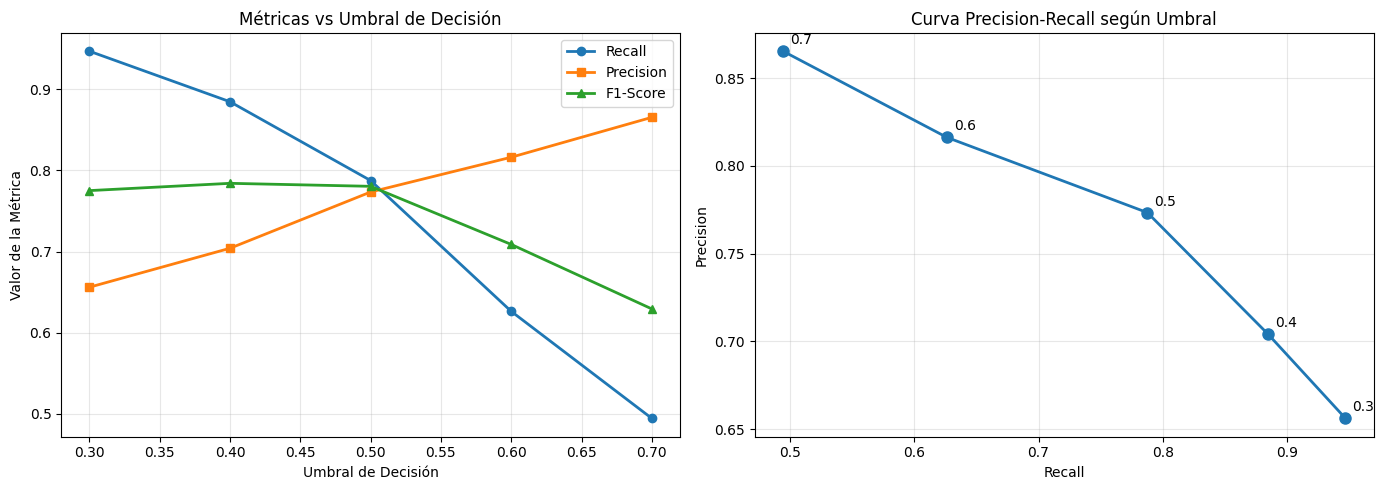

In [7]:
# Comparación de métricas según diferentes umbrales

print("="*70)
print("🎚️  ANÁLISIS DE UMBRALES DE DECISIÓN")
print("="*70)
print("\nEvaluando diferentes umbrales para la clasificación...\n")

umbrales = [0.3, 0.4, 0.5, 0.6, 0.7]
resultados = []

for umbral in umbrales:
    y_pred_umbral = (y_pred_proba >= umbral).astype(int)
    
    acc = accuracy_score(y_test, y_pred_umbral)
    rec = recall_score(y_test, y_pred_umbral)
    prec = precision_score(y_test, y_pred_umbral)
    f1 = f1_score(y_test, y_pred_umbral)
    
    resultados.append({
        'Umbral': umbral,
        'Accuracy': acc,
        'Recall': rec,
        'Precision': prec,
        'F1-Score': f1
    })

df_umbrales = pd.DataFrame(resultados)
print(df_umbrales.to_string(index=False))

print("\n" + "="*70)
print("💡 RECOMENDACIÓN:")
print("="*70)
print("• Umbral bajo (0.3-0.4): Maximiza Recall, más sensible a inundaciones")
print("  → Recomendado para sistemas de alerta temprana")
print("• Umbral medio (0.5): Balance entre Precision y Recall")
print("  → Uso general")
print("• Umbral alto (0.6-0.7): Maximiza Precision, menos falsas alarmas")
print("  → Cuando el costo de falsas alarmas es alto")
print("="*70)

# Visualizar el impacto del umbral
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(df_umbrales['Umbral'], df_umbrales['Recall'], 'o-', label='Recall', linewidth=2)
axes[0].plot(df_umbrales['Umbral'], df_umbrales['Precision'], 's-', label='Precision', linewidth=2)
axes[0].plot(df_umbrales['Umbral'], df_umbrales['F1-Score'], '^-', label='F1-Score', linewidth=2)
axes[0].set_xlabel('Umbral de Decisión')
axes[0].set_ylabel('Valor de la Métrica')
axes[0].set_title('Métricas vs Umbral de Decisión')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_umbrales['Recall'], df_umbrales['Precision'], 'o-', linewidth=2, markersize=8)
for i, umbral in enumerate(umbrales):
    axes[1].annotate(f'{umbral}', 
                     (df_umbrales.loc[i, 'Recall'], df_umbrales.loc[i, 'Precision']),
                     textcoords="offset points", xytext=(5, 5), ha='left')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Curva Precision-Recall según Umbral')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()